<a href="https://colab.research.google.com/github/Smehta1234/SkimLit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [5]:
def get_line(filenames):
    with open(filenames) as f:
        return f.readlines()


In [6]:
train_lines = get_line(data_dir + "train.txt")
train_lines[:2]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']

In [7]:
def preprocess_text_with_line_numbers(filenames):
  input_line = get_line(filenames)
  abstract_line = ""
  abstract_sample = []

  for line in input_line:
    if line.startswith("###"):
      abstract_id = line
      abstract_line = ""
    elif line.isspace():
      abstract_line_split = abstract_line.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_sample.append(line_data)
    else:
      abstract_line += line
  return abstract_sample

In [8]:
%%time
train_sample = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_sample = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_sample = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_sample), len(val_sample), len(test_sample)

CPU times: user 413 ms, sys: 81.3 ms, total: 495 ms
Wall time: 496 ms


(180040, 30212, 30135)

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_sample)
val_df = pd.DataFrame(val_sample)
test_df = pd.DataFrame(test_sample)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [10]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [11]:
from sklearn.preprocessing import OneHotEncoder

onr_hot_encoder = OneHotEncoder(sparse_output=False)

train_label_onehot = onr_hot_encoder.fit_transform(train_df[["target"]].to_numpy().reshape(-1, 1))
val_label_onehot = onr_hot_encoder.transform(val_df[["target"]].to_numpy().reshape(-1, 1))
test_label_onehot = onr_hot_encoder.transform(test_df[["target"]].to_numpy().reshape(-1, 1))
train_label_onehot.shape, val_label_onehot.shape, test_label_onehot.shape





((180040, 5), (30212, 5), (30135, 5))

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [13]:
num_classes = len(label_encoder.classes_)
class_name = label_encoder.classes_
num_classes, class_name

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#model 0 - baseline- Naive Bayes

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_label_encoded)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [15]:
model_0.score(val_sentences, val_label_encoded)

0.7218323844829869

In [16]:
baseline_preds = model_0.predict(val_sentences)
print(classification_report(val_label_encoded, baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



In [17]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-27 04:08:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-27 04:08:39 (93.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [18]:
from helper_functions import calculate_results

In [19]:
baseline_results = calculate_results(y_true=val_label_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [21]:
sen_len = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = np.mean(sen_len)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

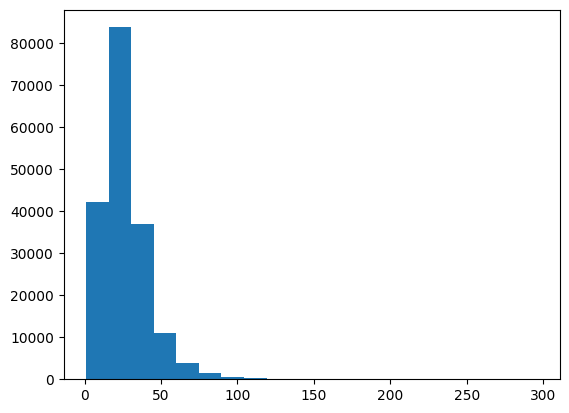

In [23]:
import matplotlib.pyplot as plt
plt.hist(sen_len,bins=20)


In [24]:
max_tokens = 68000

In [27]:
avg_sen_len = int(np.percentile(sen_len,95))

In [28]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=avg_sen_len)

In [29]:
text_vectorizer.adapt(train_sentences)

In [32]:
import random
target_text = random.choice(train_sentences)
print(f"Text:\n{target_text}\n")
print(f"Length of text:{len(target_text.split())}")
print(f"Vectorized: {text_vectorizer([target_text])}")


Text:
to examine the amount of objectively measured mvpa and lpa that is associated with long-term weight loss and the maintenance of clinically significant weight loss .

Length of text:26
Vectorized: [[   6  534    2  951    4 3503  156 4576    3 9141   28   20   81    7
   335  174  264    3    2  627    4  463   37  174  264    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")


Number of words in vocab: 64841


In [34]:
token_embedding = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [36]:
print(f"sen before vectorization: {target_text}")
vectorized_sentence = text_vectorizer([target_text])
print(f"sen after vectorization(before embedding): {vectorized_sentence}")
embedding = token_embedding(vectorized_sentence)
print(f"sentence after embedding: {embedding}")
print(f"Embedding shape: {embedding.shape}")

sen before vectorization: to examine the amount of objectively measured mvpa and lpa that is associated with long-term weight loss and the maintenance of clinically significant weight loss .
sen after vectorization(before embedding): [[   6  534    2  951    4 3503  156 4576    3 9141   28   20   81    7
   335  174  264    3    2  627    4  463   37  174  264    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
sentence after embedding: [[[-0.01710372 -0.01918029 -0.00279776 ... -0.01404194 -0.01843534
   -0.01947572]
  [ 0.03231912 -0.02778993 -0.03937073 ... -0.00500907 -0.04196851
    0.04447788]
  [ 0.01703087  0.01449278 -0.02430934 ... -0.00089348 -0.00839485
    0.0405555 ]
  ...
  [-0.0125538   0.0158458  -0.04198488 ...  0.03354065 -0.02789867
    0.02887142]
  [-0.0125538   0.0158458  -0.04198488 ...  0.03354065 -0.02789867
    0.02887142]
  [-0.0125538   0.0158458  -0.0419

In [39]:
# turn our data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_label_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_label_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_onehot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#model - 1 convo1d with token embedding

In [41]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
embedding = token_embedding(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [42]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 51, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = steps_per_epoch,
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps = validation_steps)

Epoch 1/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.8311 - loss: 0.4757 - val_accuracy: 0.8130 - val_loss: 0.5296
Epoch 2/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 78us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.8663 - loss: 0.3851 - val_accuracy: 0.8065 - val_loss: 0.5645
Epoch 4/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.8949 - loss: 0.3122 - val_accuracy: 0.7992 - val_loss: 0.6301


In [45]:
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7967 - loss: 0.6210


[0.6301246285438538, 0.7991857528686523]

In [46]:
model_1_pred_prob = model_1.predict(val_dataset)
model_1_pred_prob.shape

 50/945 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(30212, 5)

In [47]:
model_1_preds = tf.argmax(model_1_pred_prob, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
model_1_results = calculate_results(y_true=val_label_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.91857540050312,
 'precision': 0.796992411494973,
 'recall': 0.7991857540050311,
 'f1': 0.7967939086263857}